# Exploring Heart Rate Variability using Python

## Introduction

*One of the topics that got my interest last year was “Heart Rate Variability” or in short HRV. It is a popular biomarker that is used in many clinical trials and research for many years and is associated with a wide range of illnesses like diabetes, cardiovascular disease, obesity, chronic pain and stress-related diseases.*

*I am particularly interested in how you can calculate HRV manually from a raw ECG signal. In this kernel I will share my findings with you by going through a step-by-step derivation of HRV using python.*

*This kernel contains the code for my [blogpost on Medium](https://blog.orikami.nl/exploring-heart-rate-variability-using-python-483a7037c64d).*

### Imports

In [5]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import wfdb

# misc
import warnings

### Settings

In [3]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 250

### Load data

In [8]:
# data recorded with the ECG sensor
df = pd.read_csv("ecg.csv", sep=";", index_col="ms")

Using an ECG sensor, I recorded 5 minutes of my own heart rate, while laying down in a park next my office ☀️, and it worked! Let’s have a look:

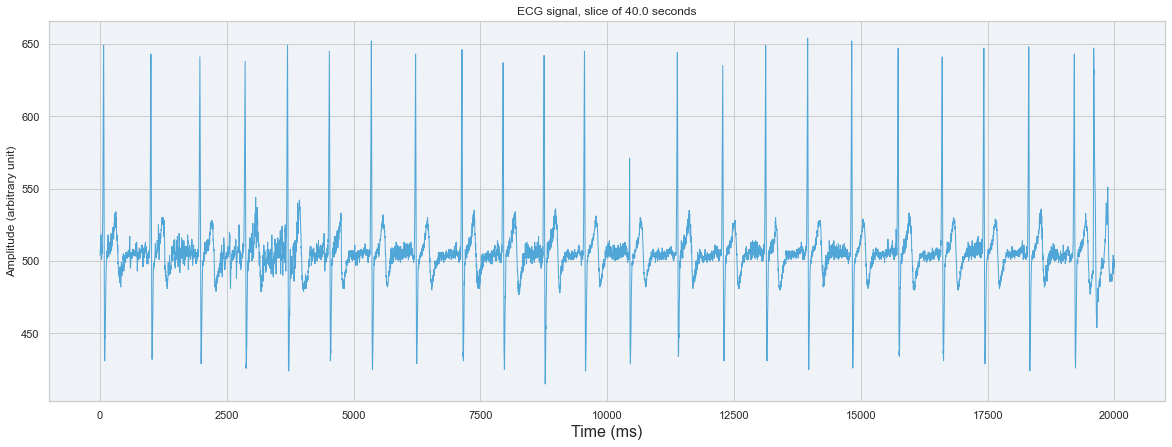

In [9]:
plt.figure(figsize=(20, 7))
start = 0
stop = 10000
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

This seems like a clean ECG signal and I suppose finding peaks won’t be much of a problem. This ECG sensor returns values as a [arbitrary units](https://en.wikipedia.org/wiki/Arbitrary_unit), so these are not real voltages. We should take just interest in the relative values. 

Let’s find out how we can find the peaks.

### Peak detection using template matching

*There are a [myriad](https://scholar.google.nl/scholar?as_sdt=1,5&q=peak+detection+ECG&hl=nl&as_ylo=2018) of different QRS detectors. Most of those consists of two stages:*

* **Stage 1 — Signal transformation
**Construct a signal that maximises the features of interest, in our case this is the QRS-complex.

* **Stage 2 — Decision rule 
**Use a threshold to separate the desired features from the rest of the signal

A lot of peak detectors use a very neat trick for transforming the signal (stage 1) and I found it worth diving into that. It’s called [template matching](https://en.wikipedia.org/wiki/Template_matching).

Template matching is widely used in pattern recognition, for example in [particle analysis](https://www.ncbi.nlm.nih.gov/pubmed/15065671), cryptanalysis, [computer vision](https://www.researchgate.net/publication/272496016_Template_Matching_Techniques_in_Computer_Vision_Theory_and_Practice) and [computational neuroscience](https://www.hindawi.com/journals/cin/2014/919406/). It’s an elegant and powerful technique that uses a filter (also known as template or kernel), that contains a **specific feature** and use that filter to find this feature in a larger signal.

![Cross-correlation is a measure of the similarity between two signals (image taken from [Giphy](https://media.giphy.com/media/VVPKOXc6aY1Lq/source.gif))](https://cdn-images-1.medium.com/max/2000/1*mWsGTGVdAsy6KoF3n3MyLA.gif)

Basic idea is to slide the filter along a signal and compute the [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) between the filter and the signal. If the filter matches a part of the signal closely, there is a strong correlation, which is another way of saying this part of the signal looks a lot like the feature in the filter. By setting a threshold (stage 2), you are able to find features you’re interested in.
>  Cross-correlation is often referred to as **convolution**, which is a slightly different operation where the filter is reversed f(t) -› f(-t) before sliding it along the signal. Convolutional Neural Networks should actually be named Cross-correlation Networks, but i guess that didn’t make it through the marketing department :-)

In images you could use this technique to find horizontal or vertical edges by designing specific filters. Convolutional Networks take this approach even further and learn filters that are relevant for certain classes automatically using back propagation.

*Allright, so template matching seems great. Lets see how we can use it to find some RR-intervals!*

In [10]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

In [11]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

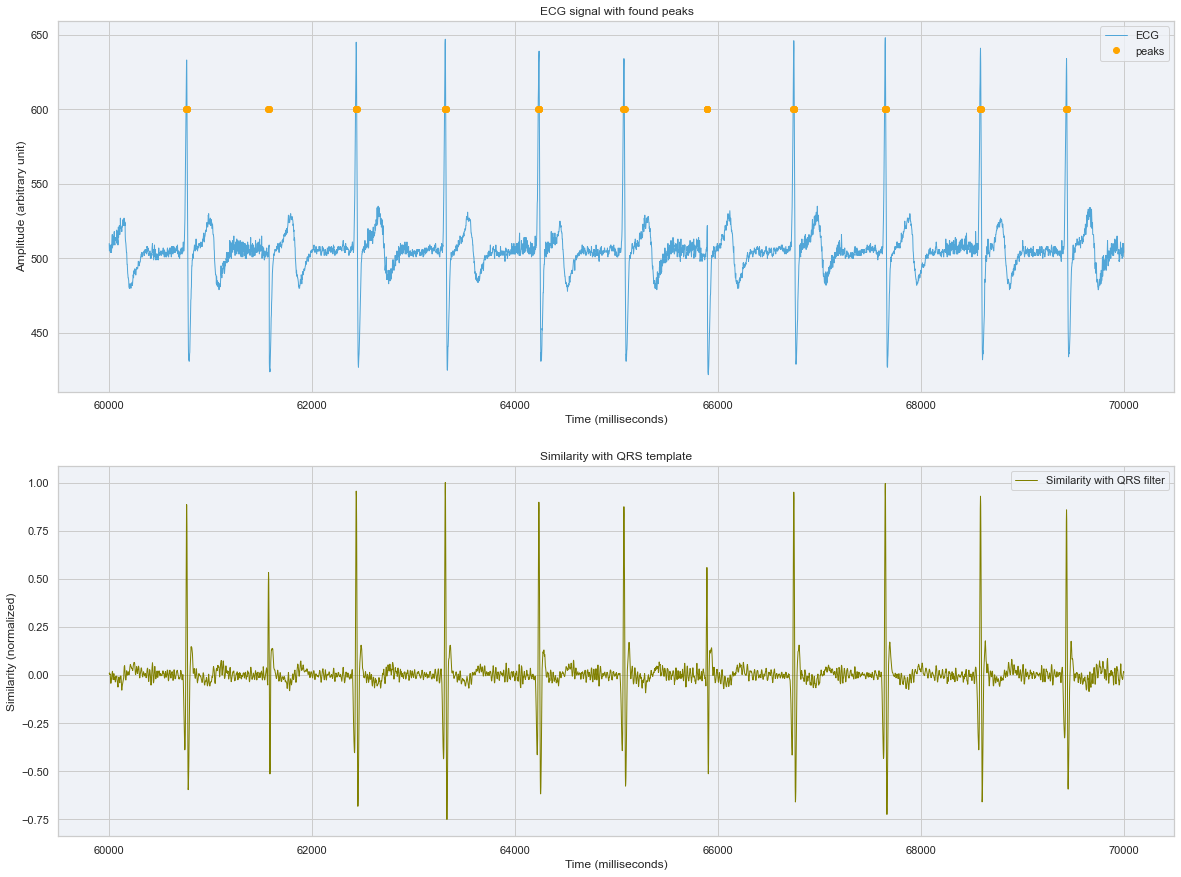

In [12]:
sampfrom = 60000
sampto = 70000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop) 
    ecg_slice = df.heartrate[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(600, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    

What’s interesting, is that there are some rather suppressed R-peaks that still have a large similarity (around 66.000 ms). If we would just use thresholding on the original signal, we’d definitely miss those peaks. Template matching **amplifies** the peaks, so it separates the features from the rest. In stage 2 we can pick these up with a threshold.

Now, as template for the peak, I just used a sine wave, which is a very simplified model for a QRS segment. Ideally, we come up with a filter that generalises well over all sorts of variants we might encounter in the world.

This makes me wonder if we could find such a “mother of all (normal) QRS segments” using labeled ECG data automatically. As I mentioned earlier, this should be possible using Convolutional Networks. 

After all, in my humble dataset this simplified QRS filter works quite well, so I’ll just use it to extract the RR-intervals.

### Group similar peaks

When using thresholding to extract the peaks, there are still multiple samples found for a single peak. To get single a value for each peak, I'll group the samples that are very near.

In [13]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

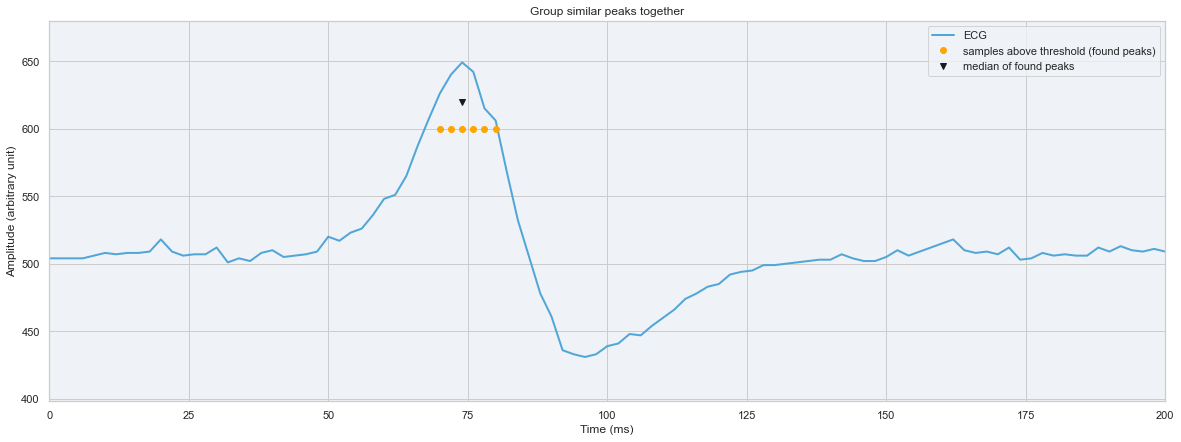

In [14]:
# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(600, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(620, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

### RR intervals: difference between successive peaks

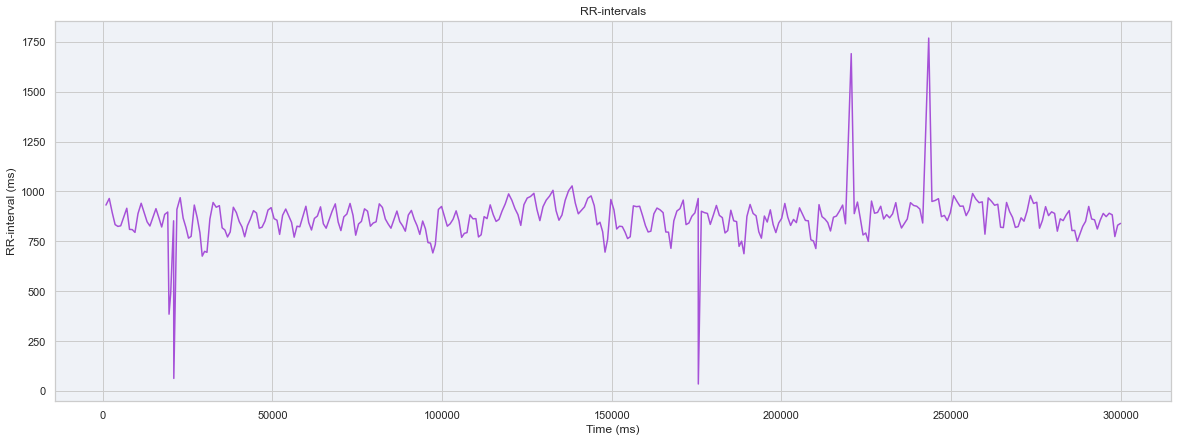

In [15]:
# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

# plot RR-intervals
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.show()

From this plot, we can see that the average RR-intervals is around 850 ms, which is about 70 BPM. We also see a couple of outliers, so I guess the peak detection is not flawless after all. When the detection algorithm misses a peak, some intervals are very large (around twice the mean). Some peaks are found very near two each other, and in that case the RR-intervals are very short.

### Error correction

If there is only a small amount of errors, we can correct them. There are different ways to correct the errors, and as a first attempt I replaced the outliers with the median value of the RR-intervals. For this, I use the [zscore](https://nl.wikipedia.org/wiki/Z-score), which is a metric for the **distance between a value and the mean of a distribution**, measured in standard deviations. By selecting RR-intervals with an absolute zscore larger than 2, we find the outliers and we can correct these by setting it to the median value.


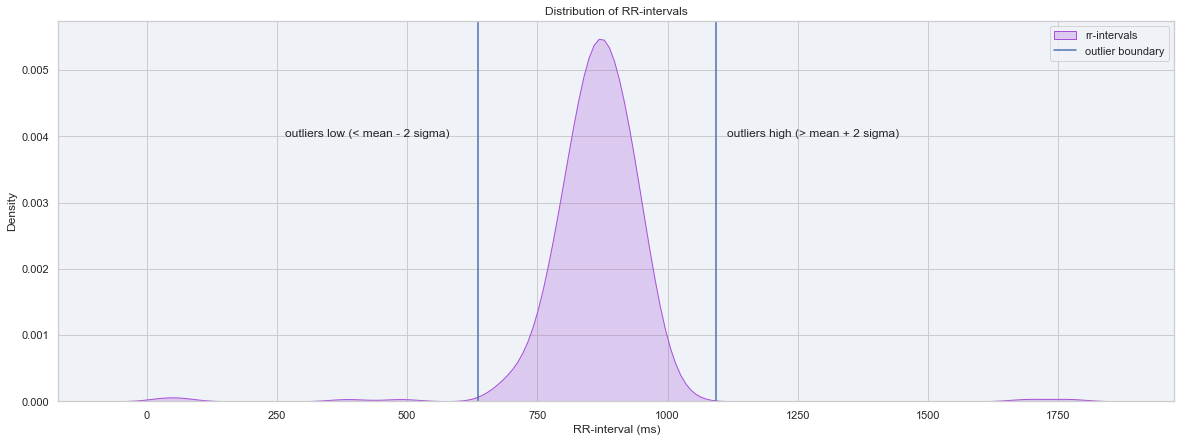

In [16]:
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

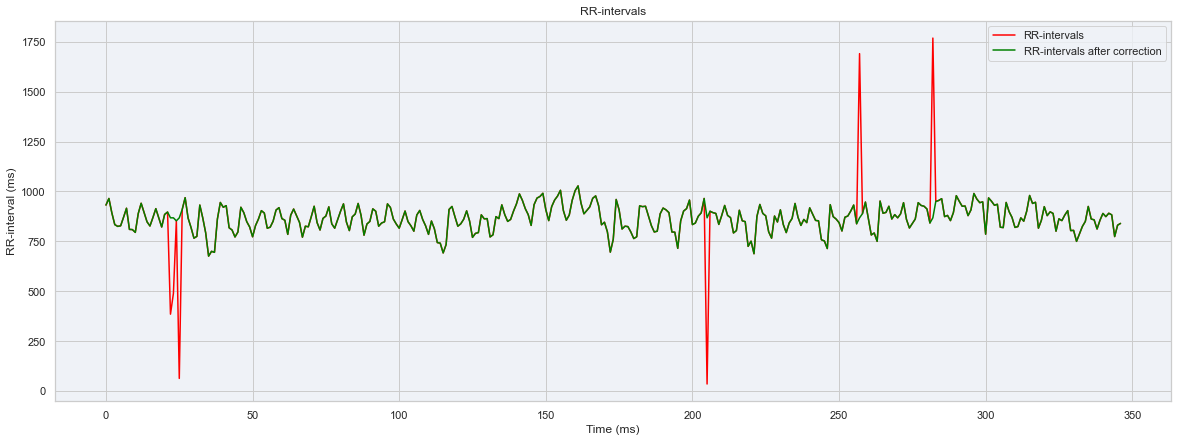

In [17]:
plt.figure(figsize=(20, 7))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

Downside of this approach is that the timings are no longer precise. For anl HRV analysis, this doesn’t have to be a big issue, but because I want to plot the RR-intervals on top of the ECG data, the alignment needs to be exact. Therefore, I corrected the errors manually as well.

### Load manually corrected rr-values

In [ ]:
rr_manual = np.loadtxt("../input/manually-corrected-rrintervals/manual-correction-rr.txt", dtype=int)

### Plot ECG signal with RR intervals

In [ ]:
sampfrom = 240000
sampto = 250000
nr_plots = 1

# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(20, 10))

    plt.title("ECG signal & RR-intervals")
    plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks, np.repeat(600, grouped_peaks.shape[0]), markersize=10, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left")
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(400, 800)
    
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr_manual)+peaks[0], rr_manual, label="Corrected RR-intervals", fillstyle="none", color="#A651D8", markeredgewidth=1, marker="o", markersize=12)
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="k", linewidth=2, marker=".", markersize=8)
    
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right")
    plt.xlabel("Time (ms)")
    plt.ylabel("RR-interval (ms)")

## Time domain analysis

Time domain methods use RR-intervals and measure a whole range of metrics, that have something to say about the variability. These metrics were standardised in a [special report of the Task Force of ESC/NASPE](https://academic.oup.com/eurheartj/article/17/3/354/485572) in 1996.

![Differences between successive RR-intervals](https://cdn-images-1.medium.com/max/3448/1*AKiF2Ht_r8V3IAOJowFIJQ.png)

**RMSSD** 

The most popular HRV metric is the Root Mean Square of Successive Differences or RMSSD. ****It’s a measure for how much variation there exists in the heart rate. In a healthy heart, there is a natural variation, which is due to a balance between the sympathetic nervous system (SNS) and parasympathetic parts (PSNS) of the Autonomous Nervous System. If your body experiences stress, then the sympathetic system will activate, to prepare for fight or flight behaviour, and your heartrate will increase. The parasympathetic controls your body’s “rest and digest” responses and is associated with recovery. Parasympathetic activation conserves energy, constricts pupils, aids digestion, and slows your heart rate. These two parts of the nervous system are normally in a healthy balance, causing a natural variation in heart. If this balance is disturbed for any reason, this variance will change. A lower RMSSD is associated with stress and various illnesses.

**Other metrics**

RMSSD is often used as the score that represents your “HRV”. It’s the most important one and it’s used in a lot of research. Here’s a list of other metrics, that are used for time domain analysis:

* **Mean RR**: mean of RR-interval

* **SDNN: **standard deviation of the RR-intervals

* **Mean HR**: the well-known mean heartrate, measured in Beats Per Minute

* **STD HR**: standard deviation of the heartrate

* **Min HR**: lowest heartrate

* **Max HR**: highest heartrate

* **NN50**: The number of pairs of successive RR-intervals that differ by more than 50 ms. *(normal RR-intervals are often called NN-intervals)*

* **PNN50**: The proportion of NN50 divided by the total number of RR-intervals.

In [ ]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [ ]:
print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))

print()
print("Time domain metrics - manually corrected RR-intervals:")
for k, v in timedomain(rr_manual).items():
    print("- %s: %.2f" % (k, v))

## Frequency domain analysis

Another approach for analysing heart rate variability is to study the power distribution in the frequency domain. It shows how much of signal lies within a certain frequency band. High (HF) frequencies between 0.15–0.40 Hz are associated with Parasympathetic activity (recovery) and lower frequencies (LF) between 0.04–0.15 Hz are linked to both sympathetic and parasympathetic activity. The ratio of LF/HF is believed to be a measure for the Autonomic Nervous System balance. A higher HF and a lower LF/HF ratio indicate an increased HRV, which means your body is recovering.

*Let’s get to it and do a frequency domain analysis on our data.*


### Interpolation

We can’t just use the RR-intervals and do a Fourier Transform, because an FFT needs evenly sampled data. We can achieve this by interpolating the data. To interpolate, we first transform our list with RR-intervals to a time series were we arrange RR-intervals over time. To find the time points for each interval, we sum up the values of the RR-intervals. Next, we create an interpolation function that we can use to sample from with any resolution we want. We use a resolution of 4 samples per second. Now we can create an evenly spaced set of datapoints that we can use for the frequency analysis.


In [ ]:
# create interpolation function based on the rr-samples. 
x = np.cumsum(rr_manual) / 1000.0
f = interp1d(x, rr_manual, kind='cubic')

In [ ]:
# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)

In [ ]:
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x, rr_manual, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 20)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx, rr_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 20)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [ ]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [ ]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

### Welch periodogram

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

## Non linear methods

### Poincare plot

In Poincaré HRV each RR interval is plotted against the next RR interval. The resulting shape of the plot is the essential feature, and can be used to identify certain types of heart failures and illnesses, is can be seen in this example.

<img src="https://i.ibb.co/3pFYDYV/poincare-example.png" alt="effects of illness and age on geometry of poincare plot" style="width:600px;"/>

In [ ]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

sd1, sd2 = plot_poincare(rr_manual)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)

### Conclusion

In this kernel, I focussed on deriving HRV from a raw ECG signal and I’ve learned a great deal:

* Diving into template matching was great fun. Previous learnings when studying convolutional networks just got new meaning, and I learned how to create my own personal peak detection algorithm, yay!
* I just love plotting with matplotlib and seaborn. You always learn a great deal when you try to create meaningful plots.
* I learned that there are still many things left to explore. Most importantly, what say about the physiological state if we measure HRV? How can we use HRV in practice as an indicator for stress or illnesses? 

I hope you found this kernel useful and if you have any questions of comments please let me know! You can find the blogpost on this topic on [Medium](https://blog.orikami.nl/exploring-heart-rate-variability-using-python-483a7037c64d).

Cheers,

Salomon Tetelepta
